# Credit Card Fraud Detection System

### Project Overview

This project implements an **end-to-end Credit Card Fraud Detection System** using Machine Learning to identify fraudulent transactions from a **highly imbalanced dataset** (fraud rate ≈ **0.58%**).

The solution focuses on:

* Robust **feature engineering**
* Handling **class imbalance**
* **Probability calibration**
* **Threshold optimization** based on business goals (high recall)
* Production-ready **ML pipelines**

---

## Dataset

* Source: <a href = 'https://www.kaggle.com/datasets/kartik2112/fraud-detection'>https://www.kaggle.com/datasets/kartik2112/fraud-detection</a>
* Contains anonymized transaction records with customer, merchant, time, location, and transaction details.
* Highly imbalanced target variable: `is_fraud`

---

## Feature Engineering

A **custom transformer (`FeatureEngineer`)** is used to encapsulate all feature engineering logic and ensure reusability.

### Time-Based Features

* Transaction hour
* Day of week
* Month
* Customer age at transaction time

### Transaction Amount

* Log-transformed transaction amount (`amt_log`) to reduce skewness

### Geospatial Features

* Haversine distance between customer location and merchant location (`distance_km`)

### Behavioral / Velocity Features

* Time since last transaction per credit card
* Binary flags for:

  * Transactions within last **1 hour**
  * Transactions within last **24 hours**

### Dropped Columns

Personally identifiable or non-informative fields (e.g., names, addresses, IDs, raw timestamps) are removed to avoid data leakage and noise.

---

## Machine Learning Pipeline

The system uses a **fully modular scikit-learn Pipeline** for clean training and inference.

### Preprocessing

* **Numerical Features**

  * Standardized using `StandardScaler`
* **Categorical Features**

  * Encoded using `OrdinalEncoder`
  * Handles unseen categories safely (`unknown_value = -1`)

### Model

* **Random Forest Classifier**

  * 300 trees
  * Controlled depth and minimum samples to reduce overfitting
  * `class_weight='balanced_subsample'` to address class imbalance
* **Probability Calibration**

  * `CalibratedClassifierCV` with **isotonic regression**
  * Produces more reliable fraud probability estimates

---

## Threshold Optimization

Instead of using the default 0.5 classification threshold, the system:

* Optimizes the threshold using the **Precision–Recall curve**
* Enforces a **minimum recall constraint (≥ 90%)**
* Selects the threshold that maximizes **F1-score** under that constraint

This aligns the model with real-world fraud detection priorities where **missing fraud is more costly than false positives**.

---

## Model Evaluation

The model is evaluated using professional, imbalanced-data-appropriate metrics:

* **Classification Report** (Precision, Recall, F1-score)
* **ROC-AUC**
* **Precision–Recall AUC**
* **Confusion Matrix**
* **ROC Curve**
* **Precision–Recall Curve**

Visualizations are generated to provide interpretability and performance insights.

---

## Model Persistence

The trained pipeline (including preprocessing and calibration) is saved using `pickle`:

```python
fraud_model_pipeline.pkl
```

This allows:

* Direct reuse for inference
* Deployment without re-training
* Consistent preprocessing during prediction

---

## Key Strengths of This Implementation

* Handles **extreme class imbalance**
* Uses **custom feature engineering inside a pipeline**
* Applies **probability calibration**
* Optimizes decisions using **business-driven thresholds**
* Production-ready and reproducible design

---

## Technologies Used

* Python
* Pandas, NumPy
* Scikit-learn
* Matplotlib, Seaborn
* Machine Learning Pipelines

Loading data...
Pipeline built.
Training model...
Training complete.

--- Model Evaluation ---
Optimized Threshold: 0.0194
Best F1 Score    : 0.2856

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    553574
           1       0.17      0.90      0.29      2145

    accuracy                           0.98    555719
   macro avg       0.58      0.94      0.64    555719
weighted avg       1.00      0.98      0.99    555719

ROC-AUC : 0.9911
PR-AUC  : 0.6379


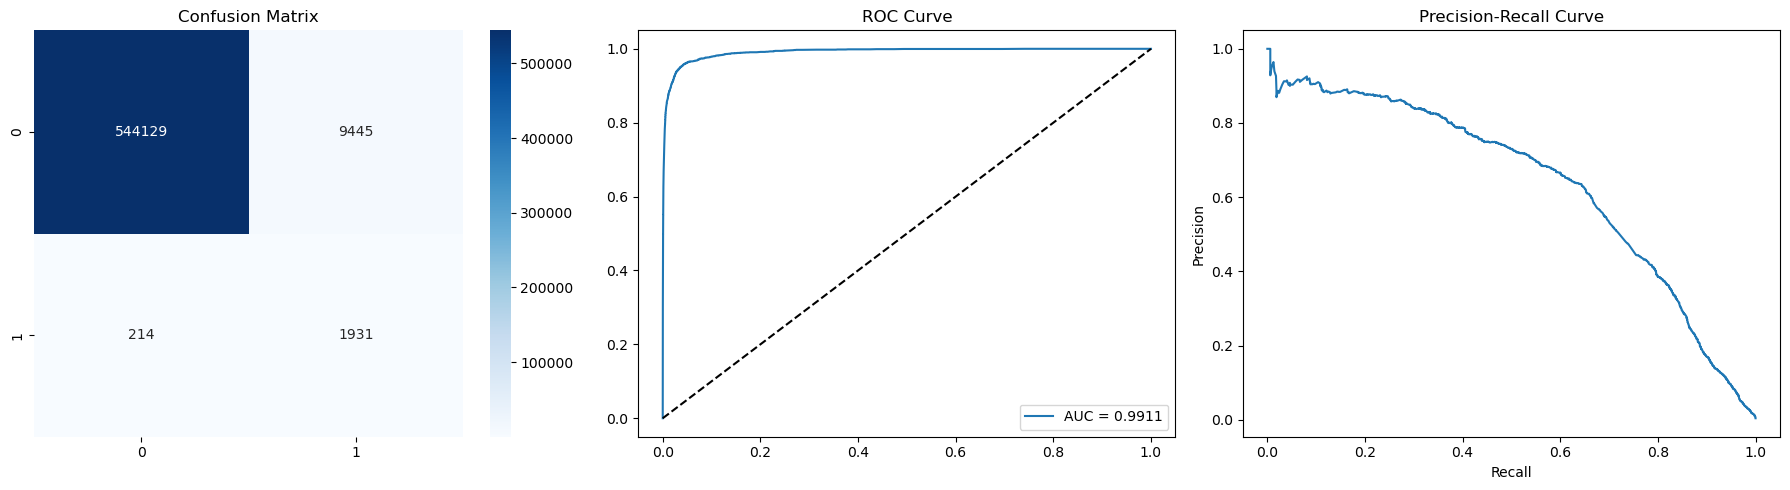

Model saved to fraud_model_pipeline.pkl


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    average_precision_score,
    precision_recall_curve
)

# Custom Feature Engineering Transformer allows us to put our feature engineering logic INSIDE the pipeline
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()

        # Convert Dates & Check if column is string before converting to avoid errors on repeated runs
        df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
        df['dob'] = pd.to_datetime(df['dob'])

        # Time features
        df['hour'] = df['trans_date_trans_time'].dt.hour
        df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
        df['month'] = df['trans_date_trans_time'].dt.month
        df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days // 365

        # Amount (log)
        df['amt_log'] = np.log1p(df['amt'])

        # Geospatial Distance
        lat1, lon1 = np.radians(df['lat']), np.radians(df['long'])
        lat2, lon2 = np.radians(df['merch_lat']), np.radians(df['merch_long'])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        df['distance_km'] = 6371 * c

        # velocity Features
        df = df.sort_values(['cc_num', 'trans_date_trans_time'])

        df['time_since_last_tx'] = (
            df.groupby('cc_num')['trans_date_trans_time']
            .diff()
            .dt.total_seconds()
            .fillna(999999)
        )

        df['tx_1h'] = (
            df['time_since_last_tx'] < 3600
        ).astype(int)

        df['tx_24h'] = (
            df['time_since_last_tx'] < 86400
        ).astype(int)

        # Drop unwanted
        drop_cols = [
            'Unnamed: 0', 'cc_num', 'merchant', 'first', 'last',
            'street', 'city', 'zip', 'trans_num', 'unix_time',
            'trans_date_trans_time', 'dob'
        ]

        return df.drop(columns=drop_cols, errors='ignore')


# threshold optimization
def find_best_threshold(y_true, y_prob, min_recall=0.90):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

    best_t = 0.5
    best_f1 = 0

    for p, r, t in zip(precision, recall, thresholds):
        if r >= min_recall and (p + r) > 0:
            f1 = 2 * (p * r) / (p + r)
            if f1 > best_f1:
                best_f1 = f1
                best_t = t

    return best_t, best_f1


# The Main Fraud-Detector Class
class FraudDetector:
    def __init__(self):
        self.pipeline = None

    def build_pipeline(self, numeric_features, categorical_features):
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric_features),
                ('cat', OrdinalEncoder(
                    handle_unknown='use_encoded_value',
                    unknown_value=-1
                ), categorical_features)
            ]
        )

        rf = RandomForestClassifier(
            n_estimators=300,
            max_depth=20,
            min_samples_leaf=50,
            min_samples_split=100,
            max_features='sqrt',
            class_weight='balanced_subsample',
            n_jobs=-1,
            random_state=42
        )

        clf = CalibratedClassifierCV(
            rf,
            method='isotonic',
            cv=3
        )

        self.pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', clf)
        ])

        print("Pipeline built.")

    def train(self, X, y):
        print("Training model...")
        self.pipeline.fit(X, y)
        print("Training complete.")

    def evaluate(self, X_test, y_test, min_recall=0.90):
        print("\n--- Model Evaluation ---")

        y_prob = self.pipeline.predict_proba(X_test)[:, 1]

        best_t, best_f1 = find_best_threshold(y_test, y_prob, min_recall)
        y_pred = (y_prob >= best_t).astype(int)

        print(f"Optimized Threshold: {best_t:.4f}")
        print(f"Best F1 Score    : {best_f1:.4f}\n")

        print(classification_report(y_test, y_pred))

        roc_auc = roc_auc_score(y_test, y_prob)
        pr_auc = average_precision_score(y_test, y_prob)

        print(f"ROC-AUC : {roc_auc:.4f}")
        print(f"PR-AUC  : {pr_auc:.4f}")

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Confusion Matrix
        sns.heatmap(
            confusion_matrix(y_test, y_pred),
            annot=True,
            fmt='d',
            cmap='Blues',
            ax=axes[0]
        )
        axes[0].set_title("Confusion Matrix")

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
        axes[1].plot([0, 1], [0, 1], 'k--')
        axes[1].set_title("ROC Curve")
        axes[1].legend()

        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        axes[2].plot(recall, precision)
        axes[2].set_title("Precision-Recall Curve")
        axes[2].set_xlabel("Recall")
        axes[2].set_ylabel("Precision")

        plt.tight_layout()
        plt.show()

    def save_model(self, filename="fraud_model_pipeline.pkl"):
        with open(filename, "wb") as f:
            pickle.dump(self.pipeline, f)
        print(f"Model saved to {filename}")


# Data Loading....
print("Loading data...")
train_raw = pd.read_csv("Dataset/fraudTrain.csv")
test_raw = pd.read_csv("Dataset/fraudTest.csv")

# Initiaing custom transformer
fe = FeatureEngineer()
train_processed = fe.transform(train_raw)
test_processed = fe.transform(test_raw)

# Defining Feature Sets
X_train = train_processed.drop("is_fraud", axis=1)
y_train = train_processed["is_fraud"]
X_test = test_processed.drop("is_fraud", axis=1)
y_test = test_processed["is_fraud"]

# Identifying numeric vs categorical columns automatically
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

# Initialize and Train
detector = FraudDetector()
detector.build_pipeline(numeric_cols, categorical_cols)
detector.train(X_train, y_train)

# Evaluate
detector.evaluate(X_test, y_test, min_recall=0.90)

detector.save_model() # Save the model